# Processamento Digital de Sinais
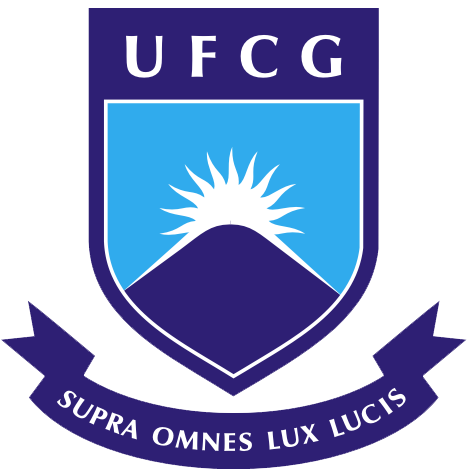
### Aluno: 
- Elmer Pimentel Farias

### Professor: 
- Dr. Edmar Candeia Gurjão, Professor do Departamento de Engenharia Elétrica da Universidade Federal de Campina Grande (UFCG)

## Implementando a FFT em Python

### O Algoritmo FFT (Cooley-Tukey)

O algoritmo **FFT Radix-2 DIT** decompõe recursivamente uma DFT de tamanho $N$ em DFTs menores de tamanho $N/2$. A abordagem iterativa reorganiza o cálculo em "**estágios**". Para uma FFT de $N$ pontos (onde $N$ é uma potência de 2), haverá $\log_2(N)$ estágios.

-----

### O Diagrama Borboleta

A visualização padrão para a FFT é o **diagrama borboleta** (*butterfly*), que mostra o fluxo de dados e as operações.

> **(FFT, N=8)**
![Captura de tela 2025-10-17 164218.png](<attachment:Captura de tela 2025-10-17 164218.png>)

A operação fundamental em cada estágio é a "**borboleta**" **Radix-2**, que pega duas entradas e produz duas saídas.

> **(FFT, N=2)**
![Captura de tela 2025-10-17 164532.png](<attachment:Captura de tela 2025-10-17 164532.png>)
-----

### Cálculo "In-Place" (Na Própria Memória)

Uma característica poderosa da FFT iterativa é que ela pode ser calculada "**in-place**", **reutilizando o mesmo buffer de memória** que contém as amostras de entrada para armazenar os resultados intermediários e a saída final. Isso é crucial para sistemas com memória limitada.

Podemos visualizar isso redesenhando o diagrama de fluxo para focar nos elementos de memória (`Mem[a]`, `Mem[b]`) e como seus valores são atualizados em cada estágio.

> **Transição das Butterflys entre os estágios de memória**
![Captura de tela 2025-10-17 165413.png](<attachment:Captura de tela 2025-10-17 165413.png>)
-----

### A Operação Borboleta (Butterfly)

A operação central que acontece em cada borboleta é a seguinte. Para dois elementos de memória, `Mem[a]` e `Mem[b]`, e um fator de rotação $W$:

$$
\begin{aligned}
\text{temp} &= W \cdot \text{Mem}[b] \\
\text{Mem}[b] &= \text{Mem}[a] - \text{temp} \\
\text{Mem}[a] &= \text{Mem}[a] + \text{temp}
\end{aligned}
$$

Note que um valor **temporário** (`temp`) é necessário para realizar o cálculo corretamente na mesma memória.

-----

### Reversão de Bits (Bit-Reversal)

A abordagem iterativa DIT (Decimation-in-Time) requer que as amostras de entrada $x[n]$ sejam **reordenadas** antes do início do primeiro estágio. A ordem correta é a "**reversão de bits**" (*bit-reversal*) dos índices.

-----

### Estrutura de Loops (Pseudo-código)

Para implementar a FFT iterativa, podemos analisar os padrões numéricos nos estágios. Isso leva a uma estrutura de **loops aninhados**.

```
N = numero_de_amostras
log2N = log2(N)

// Loop através dos estágios
para stage de 1 até log2N:
  tamanho_bloco = 2^stage
  meio_bloco = 2^(stage-1)
  
  // Loop através dos blocos de cálculo
  para k de 0 até (N-1) incrementando por tamanho_bloco:
    
    // Loop dentro de cada bloco (operações borboleta)
    para j de 0 até (meio_bloco-1):
      
      // Índices dos elementos
      a = k + j
      b = k + j + meio_bloco
      
      // Calcular fator de rotação W
      W = twiddle_factor(j, tamanho_bloco)
      
      // Executar a borboleta
      temp = W * Mem[b]
      Mem[b] = Mem[a] - temp
      Mem[a] = Mem[a] + temp
```
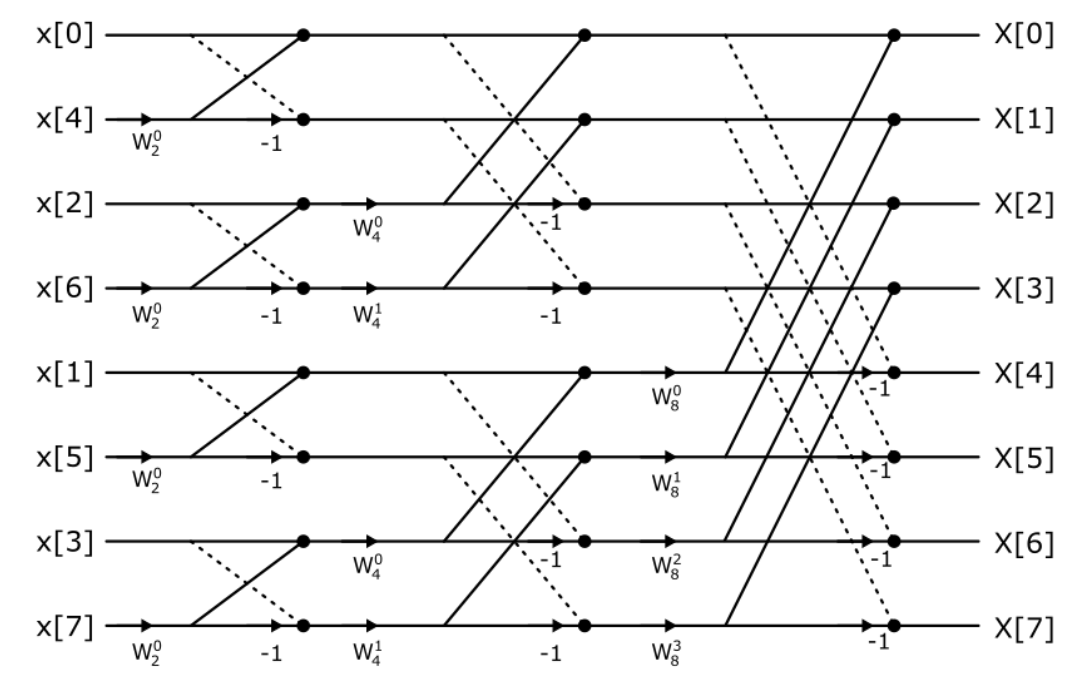
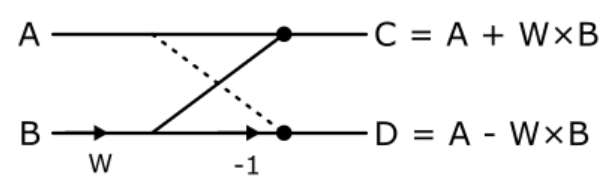
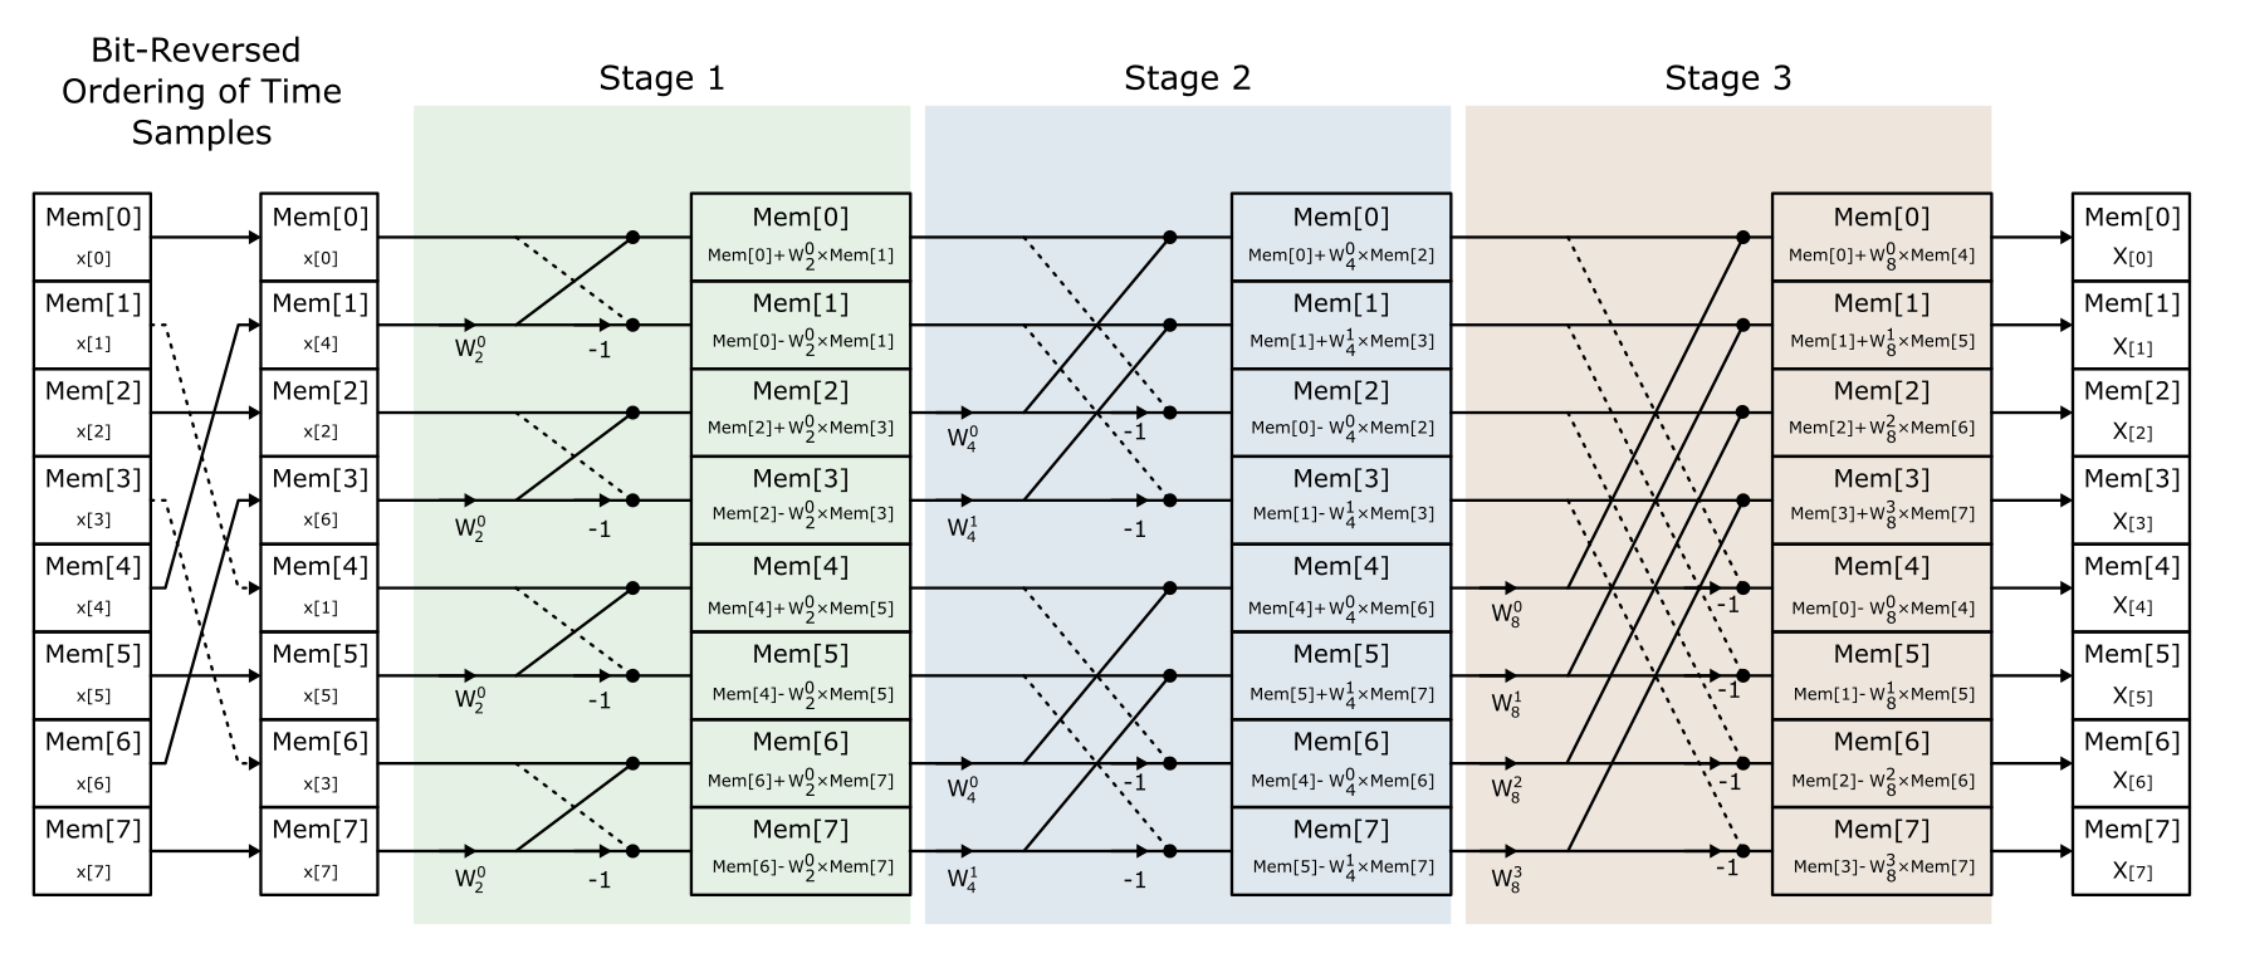

### Bibliotecas Utilizadas


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import njit, prange

### Reversão dos Bits

In [3]:
import numpy as np
from numba import njit, prange
@njit
def bits_reverse(N):
    """
    Gera um vetor de índices de 0 a N-1 com a ordem invertida em bits.
    Usado na reorganização do vetor de entrada da FFT radix-2.
    
    Parâmetro:
        N : int
            Tamanho do vetor (deve ser potência de 2)
    
    Retorno:
        indices_reversos : ndarray de int
            Vetor de índices com bits invertidos
    """
    bits = (np.log2(N))
    indices_reversos = np.zeros(N, dtype=np.int32)

    for i in range(N):
        rev = 0
        temp = i
        for b in range(bits):
            rev = (rev << 1) | (temp & 1)
            temp >>= 1
        indices_reversos[i] = rev

    return indices_reversos


### Implementação da FFT com Decoradores NUMBA

In [4]:
@njit
def FFT_func_Numba(x, N):
    """
    Versão njit da FFT que calcula internamente próxima potência de 2
    e aplica zero-padding/truncamento sem chamadas externas.
    """
    L = len(x)

    # próxima potência de 2 >= N (sem bit_length)
    if N <= 1:
        N_fft = 1
    else:
        p = 1
        while p < N:
            p <<= 1
        N_fft = p

    # inicializa vetor complexo X com tamanho N_fft e aplica zero-padding/truncamento
    X = np.zeros(N_fft, dtype=np.complex128)
    lim = L if L < N_fft else N_fft
    for i in range(lim):
        X[i] = complex(x[i])

    # reordenação bit-reversal
    indices = bits_reverse(N_fft)
    X = X[indices]

    # estágios da FFT
    stages = int(np.log2(N_fft))
    for s in range(1, stages + 1):
        m = 2 ** s
        wm = np.exp(-2j * np.pi / m)
        for k in range(0, N_fft, m):
            w = 1.0 + 0j
            for j in prange(m // 2):
                u = X[k + j]
                t = w * X[k + j + m // 2]
                X[k + j] = u + t
                X[k + j + m // 2] = u - t
                w *= wm

    # normalização
    norm = 1 / np.sqrt(N_fft)
    for i in range(N_fft):
        X[i] *= norm

    return X, N_fft # Retorna o resultado e o N efetivamente usado

### Função para melhorar visualzização nos plots da FFT

In [5]:
def fft_freq(N, Ts):
    
    freqs = np.zeros(N)
    
    for k in range(N):
        
        if k < N//2: # Positive frequencies
            freqs[k] = k / (N * Ts)
            
        else: # Negative frequencies
            freqs[k] = (k - N) / (N * Ts)
            
    return freqs


#### IFFT

In [14]:
def ifft_iterative(x):
    """
    Implementação da IFFT (radix-2) iterativa com Numba.
    Normalização simétrica: 1/sqrt(N)
    """
    N = len(x)
    X = np.empty_like(x) # Cria uma cópia para não modificar o original
    for i in range(N):
        X[i] = x[i]

    # Reordenação bit-reversal
    indices = bits_reverse(N)
    X = X[indices]

    # Estágios (sinal invertido nos expoentes)
    stages = int(np.log2(N))
    for s in range(1, stages + 1):
        m = 2 ** s
        wm = np.exp(+2j * np.pi / m)
        for k in range(0, N, m):
            w = 1.0 + 0j
            for j in range(m // 2):
                u = X[k + j]
                t = w * X[k + j + m // 2]
                X[k + j] = u + t
                X[k + j + m // 2] = u - t
                w *= wm

    # Normalização simétrica
    return X / np.sqrt(N)

### DFT Matricial

In [6]:

def DFT_func_matricial(signal, N):
    """
    Calcula a Transformada Discreta de Fourier (DFT) de forma matricial.

    Args:
        signal (array-like): O sinal de entrada.
        N (int): O número de pontos da DFT.

    Returns:
        numpy.ndarray: O vetor da DFT normalizada.
    """
    L = len(signal)
    
    # 1. Preparação/Ajuste do Sinal (Zero Padding ou Truncamento)
    sig = np.zeros(N, dtype=signal.dtype)
    if L < N:
        sig[:L] = signal  # Zero Padding
    else:
        sig = signal[0:N] # Truncamento
        
    # Certifica-se de que o tipo de dado é complexo para o cálculo subsequente
    sig = sig.astype(np.complex128)

    # 2. Construção da Matriz de Fourier (W)
    # n e k variam de 0 a N-1.
    n = np.arange(N)
    k = n.reshape((N, 1)) # Transpõe 'n' para que 'k' seja uma coluna (N x 1)

    # O expoente é: -2j * pi * k * n / N
    # k e n são vetores, k*n resultará em uma matriz (N x N)
    exponent = (-2j * np.pi * k * n) / N
    
    # A Matriz de Fourier (W) é calculada como e^(expoente)
    W = np.exp(exponent)
    # 

    # 3. Multiplicação Matricial
    # X[k] = sum_{n=0}^{N-1} sig[n] * W[k, n]
    # Isso é exatamente o produto da Matriz W (N x N) pelo vetor sig (N x 1)
    X = W @ sig 
    # Alternativamente: X = np.dot(W, sig)

    # 4. Normalização
    return X / np.sqrt(N)

### Aplicação da FFT em um tamanho N e Sinal X(n), Comparação de DFT x FFT

Tamanho original do sinal: 700
Tamanho da FFT após padding (potência de 2): 1024


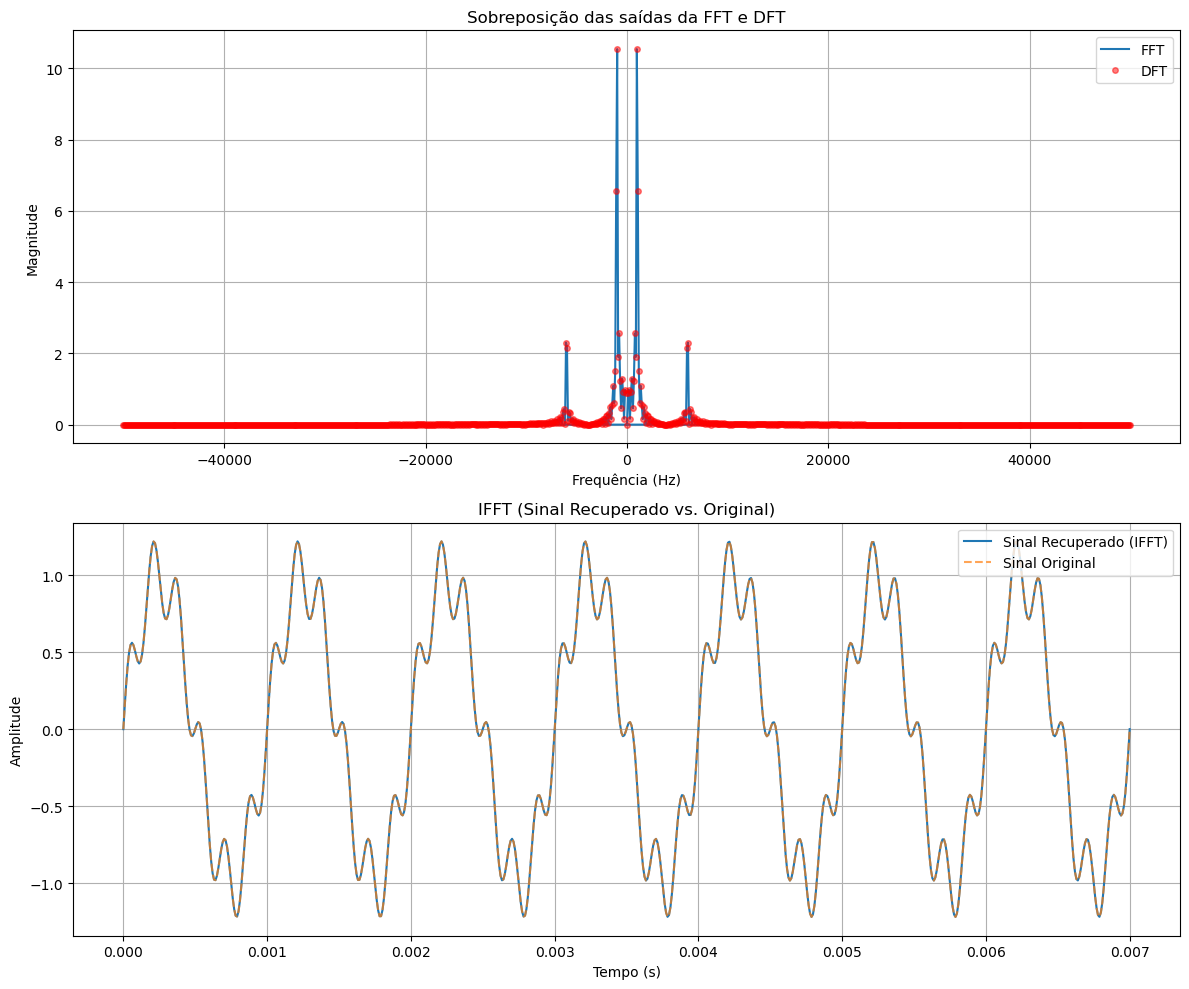

In [23]:
N = 700  # Tamanho original do sinal
Fs = 100e3
Ts = 1 / Fs
f1 = 1e3
f2 = 6e3

# Gera o sinal com N pontos
x_time = np.linspace(0.0, N * Ts, N)
y_signal = np.sin(f1 * 2.0 * np.pi * x_time) + 0.25 * np.sin(f2 * 2.0 * np.pi * x_time)


# A função agora retorna yf (resultado) e N_fft (o N real usado)
fft1, N_fft = FFT_func_Numba(y_signal, N)
dft1 = DFT_func_matricial(y_signal, N_fft)
# Usa N_fft para gerar o eixo de frequência corretamente
freq = fft_freq(N_fft, Ts)

print(f"Tamanho original do sinal: {N}")
print(f"Tamanho da FFT após padding (potência de 2): {N_fft}")

fig, axs = plt.subplots(2, 1, figsize=(12, 10))

axs[0].plot(freq, np.abs(fft1), label='FFT')
axs[0].plot(freq, np.abs(dft1), 'ro', label='DFT', markersize=4, alpha=0.5)
axs[0].set_title('Sobreposição das saídas da FFT e DFT')
axs[0].set_xlabel('Frequência (Hz)')
axs[0].set_ylabel('Magnitude')
axs[0].legend()
axs[0].grid(True)

y_recovered = ifft_iterative(fft1)


# Plota apenas os primeiros N pontos do sinal recuperado contra o tempo original
axs[1].plot(x_time, y_recovered[:N].real, label="Sinal Recuperado (IFFT)")
axs[1].plot(x_time, y_signal, linestyle='--', label="Sinal Original", alpha=0.7)
axs[1].grid(True)
axs[1].set_title("IFFT (Sinal Recuperado vs. Original)")
axs[1].set_xlabel("Tempo (s)")
axs[1].set_ylabel("Amplitude")
axs[1].legend()

plt.tight_layout()
plt.show()

### Comparando a DFT Matricial x FFT com Decorador Numba

Esquentando o Numba com uma FFT de teste...
Aquecimento concluído.
Iniciando a comparação de tempo... 
Tempo gasto na DFT para N=64: 0.000224 s
Tempo gasto na FFT para N=64: 0.000009 s
Tempo gasto na DFT para N=128: 0.000503 s
Tempo gasto na FFT para N=128: 0.000009 s
Tempo gasto na DFT para N=256: 0.001756 s
Tempo gasto na FFT para N=256: 0.000014 s
Tempo gasto na DFT para N=512: 0.005821 s
Tempo gasto na FFT para N=512: 0.000015 s
Tempo gasto na DFT para N=1024: 0.022787 s
Tempo gasto na FFT para N=1024: 0.000032 s
Tempo gasto na DFT para N=2048: 0.088273 s
Tempo gasto na FFT para N=2048: 0.000048 s
Tempo gasto na DFT para N=4096: 0.364716 s
Tempo gasto na FFT para N=4096: 0.000092 s
Tempo gasto na DFT para N=8192: 1.404197 s
Tempo gasto na FFT para N=8192: 0.000166 s
Teste finalizado.


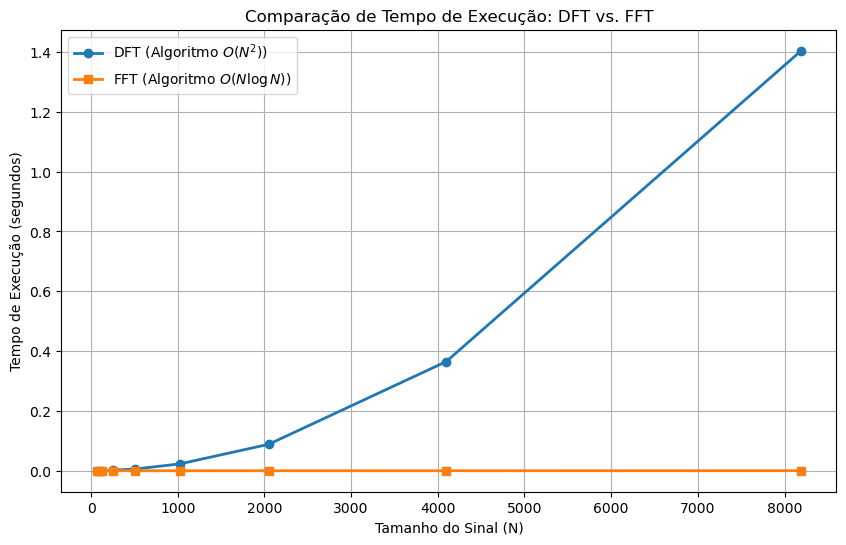

In [10]:

# Esquentar o NUMBA
print("Esquentando o Numba com uma FFT de teste...")   
sinal_teste_aquecimento = np.random.randn(32)
FFT_func_Numba(sinal_teste_aquecimento, N=32)
print("Aquecimento concluído.")


# Vamos testar para diferentes tamanhos de N.
tamanhos_N = [64, 128, 256, 512, 1024, 2048, 4096, 8192]
tempos_dft = []
tempos_fft = []

print("Iniciando a comparação de tempo... ")

#  Loop de Medição 
for N in tamanhos_N:
    # Cria um sinal de teste aleatório
    sinal_teste = np.random.randn(N)

    # Mede o tempo da DFT
    inicio_dft = time.time()
    DFT_func_matricial(signal=sinal_teste, N=N)
    fim_dft = time.time()
    tempos_dft.append(fim_dft - inicio_dft)
    print(f'Tempo gasto na DFT para N={N}: {tempos_dft[-1]:.6f} s')

    # Mede o tempo da FFT
    inicio_fft = time.time()
    FFT_func_Numba(sinal_teste, N=N)
    fim_fft = time.time()
    tempos_fft.append(fim_fft - inicio_fft)
    print(f'Tempo gasto na FFT para N={N}: {tempos_fft[-1]:.6f} s')

print("Teste finalizado.")

# Plotando o Gráfico de Comparação
plt.figure(figsize=(10, 6))
plt.plot(tamanhos_N, tempos_dft, 'o-', label='DFT (Algoritmo $O(N^2)$)', linewidth=2)
plt.plot(tamanhos_N, tempos_fft, 's-', label='FFT (Algoritmo $O(N \log N)$)', linewidth=2)

plt.title('Comparação de Tempo de Execução: DFT vs. FFT')
plt.xlabel('Tamanho do Sinal (N)')
plt.ylabel('Tempo de Execução (segundos)')
plt.legend()
plt.grid(True)
# Usar escala logarítmica no eixo Y ajuda a visualizar a enorme diferença ou nao 
#plt.yscale('log')
plt.show()